**Numerical functions**

In many applications we have do not have access to analytical functions $Y(\boldsymbol{x})$, but rather we have the ability to evaluate them at an arbitrary set of quadrature points $\{\boldsymbol{x}_q\}$. Given that our approach to computing CDF the of $Y(\boldsymbol{x})$
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\boldsymbol{x}) d \boldsymbol{x},
\end{equation*}
utilises numerical quadrature in order to evaluate a projection of the indicator function given by
\begin{equation*}
    \mathbb{I}(y,\boldsymbol{x}) =
    \begin{cases}
    1 \quad &: Y(\boldsymbol{x}) < y, \\
    0 \quad &: \text{otherwise},
    \end{cases}
\end{equation*}
this implies that by using a sufficiently high degree of numerical quadrature we can exploit the functional form of $Y(\boldsymbol{x})$. In instances where the function is calculated using a psuedo-spectral or finite element method this is therefore particularly powerful.

In this notebook we consider two different examples of how to calculate the CDF from externally generated data. Both examples are chosen have a unit square mesh and a function with range $[0, 1]$. To begin implementing these examples we first import *firedrake* and *Ptp*.

In [1]:
from chist import Ptp
from firedrake import *
from firedrake.__future__ import interpolate

and then create a *ptp* object corresponding to a function $Y(\boldsymbol{x})$ on a unit square mesh, with range $[0, 1]$.

In [2]:
ptp = Ptp(Omega_X={'x1': (0, 1), 'x2': (0, 1)}, Omega_Y={'Y': (0, 1)}, n_elements=10)

**Example 1: numpy function**

As a first example we consider specifying the function $Y(\boldsymbol{x}) = (x_1 + x_2)/2$ in terms of numpy arrays as implemented below

In [3]:
def Y_numerical(X):
    """Returns Y = (X[0] + X[1])/2"""
    return (X[:,0] + X[:,1])/2

In order to be able to call the *fit* method on this function we first need to express its evaluation at the quadrature points that the equivalent analytical expression would be evaluated at, that is

In [4]:
x1, x2 = ptp.x_coords()
Y_anal = (x1 + x2)/2

For this purpose we set up a *Quadrature Element* that will contain the required evaluations of *Y_numerical*. This is implemented below in terms of the function *external_function*

In [5]:
def external_function(ptp, Y_numerical, quadrature_degree):
    """
    Return Y_numerical(x_q) at the quadrature points x_q, 
    specified by the quadrature degree.

    Parameters
    ----------
    ptp : Ptp object
        Object containing the mesh
    Y_numerical: callable
        Numerical representation of the function Y(x)
    quadrature_degree: int
        Order of the quadrature scheme to use.

    Returns
    -------
    Y : firedrake Function
        Y_numerical evaluated at points x_q of a quadrature mesh.
    """
    V_YE = FiniteElement(family="Quadrature", cell="quadrilateral", degree=quadrature_degree, quad_scheme='default')
    V_Y = FunctionSpace(mesh=ptp.m_yx, family=V_YE)
    Y = Function(V_Y)

    m = V_Y.mesh()
    W = VectorFunctionSpace(m, V_Y.ufl_element())
    x_vec = assemble(interpolate(m.coordinates, W))
    
    x_q = x_vec.dat.data_ro[:,:-1]

    Y.dat.data[:] = Y_numerical(x_q)

    return Y

Using *external function* we can then obtai the required representation of Y to pass to the *ptp.fit* method. Note that the *quadrature_degree* parameter passed to both functions must be the same

In [6]:
quadrature_degree = 50
Y_num = external_function(ptp, Y_numerical, quadrature_degree)

To check the implementation of our method we can compare the result from the analytical and numerical functions

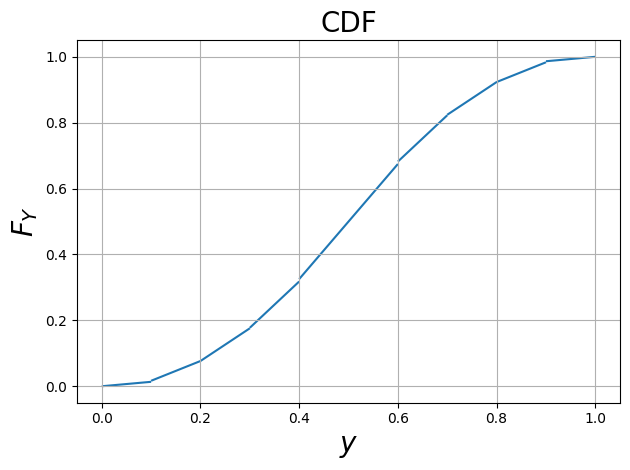

In [7]:
density = ptp.fit(Y_num, quadrature_degree)
density.plot()

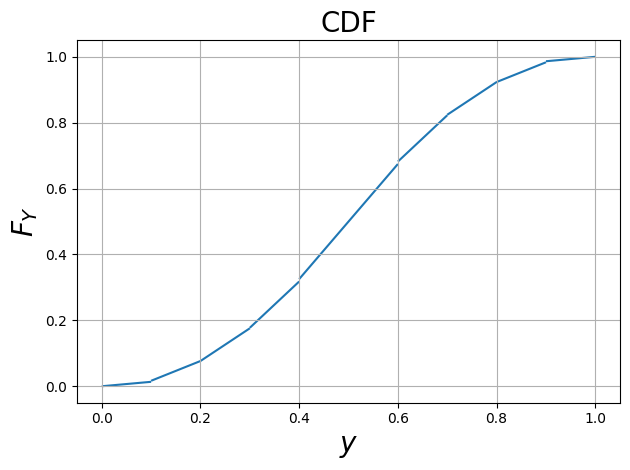

In [8]:
density = ptp.fit(Y_anal, quadrature_degree)
density.plot()

**Example 2: Finite Element method**

As a second example we compute the cdf of the temperature field $T(\boldsymbol{X})$ generated using *firedrake* as plotted below.

In [9]:
from rayleigh_benard import rbc
u,p,T = rbc()

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  0 SNES Function norm 1.173882104775e+00
  1 SNES Function norm 7.082656625111e-03
  2 SNES Function norm 1.419221703945e-04
  3 SNES Function norm 2.292309994681e-07
  4 SNES Function norm 4.335991464901e-13
  0 SNES Function norm 1.173882104775e+00
  1 SNES Function norm 7.082656640705e-03
  2 SNES Function norm 1.419175569562e-04
  3 SNES Function norm 2.291953939738e-07
  4 SNES Function norm 5.309551185905e-13
  0 SNES Function norm 1.173882104775e+00
  1 SNES Function norm 7.082659982085e-03
  2 SNES Function norm 1.419220577544e-04
  3 SNES Function norm 2.292340675623e-07
  4 SNES Function norm 6.426599670613e-13


Text(0, 0.5, '$X_2$')

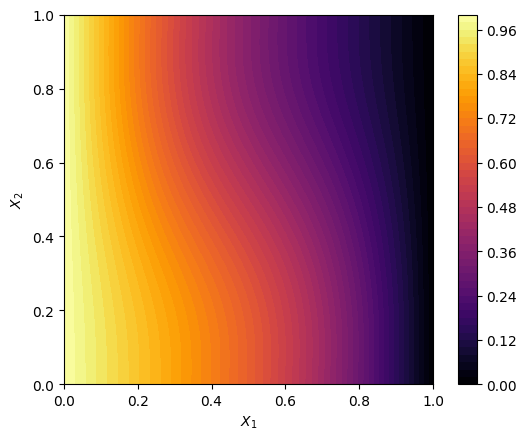

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from firedrake.pyplot import tricontourf

fig, axes = plt.subplots()
levels = np.linspace(0, 1, 51)
contours = tricontourf(T, levels=levels, axes=axes, cmap="inferno")
axes.set_aspect("equal")
fig.colorbar(contours)
axes.set_xlabel(r'$x_1$')
axes.set_ylabel(r'$x_2$')

As per the previous example we write a function *Y_numerical* which returns the value of the function at the quadrature points required to perform the evaluation of the cdf. 

In [11]:
def Y_numerical(x):
    """Returns firedrake function T(x) at the vector of points x = [x1, x2]."""
    return T.at(x)

By passing this function to *external_function* we can then call the fit method

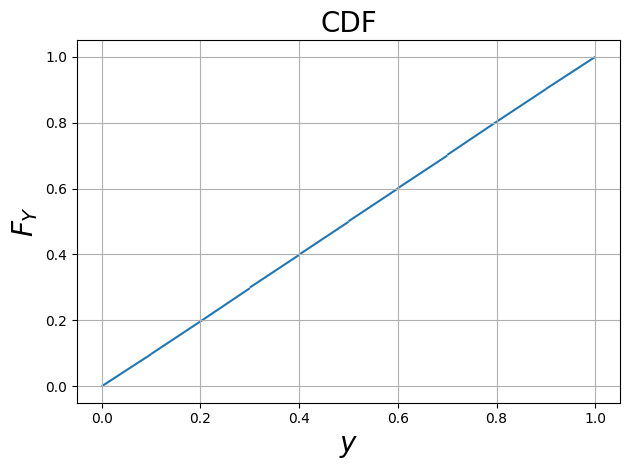

In [12]:
quadrature_degree = 50
Y_num = external_function(ptp, Y_numerical, quadrature_degree)
density = ptp.fit(Y_num, quadrature_degree)
density.plot()